In [215]:
import torch
from torch.utils.data import Subset,DataLoader, TensorDataset, ConcatDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [216]:
batch_size = 64
num_classes = 10
epochs = 10

In [217]:
train_set = datasets.MNIST('/content',train=True,download=True)
test_set = datasets.MNIST('/content',train=False,download=True)

### Preprocessing

In [218]:
# inversion and normalization
invert = lambda image : 1 - image # function to invert the image
normalize = lambda image : image / 255 # function for bringing pixel values in range [0,1]

def preprocessing(dataset):
    dataset_images = dataset.data.numpy() # convert the dataset into numpy array
    dataset_labels = dataset.targets.numpy() # convert the labels into numpy array
    dataset_images = normalize(dataset_images)
    dataset_images = invert(dataset_images)
    return dataset_images,dataset_labels

train_images,train_labels = preprocessing(train_set)
test_images,test_labels = preprocessing(test_set)

### Prepare the data

In [219]:
training_set = TensorDataset(torch.Tensor(train_images),torch.Tensor(train_labels).to(torch.int64))
testing_set = TensorDataset(torch.Tensor(test_images),torch.Tensor(test_labels).to(torch.int64))
# print(torch.Tensor(train_labels).to(torch.int64).dtype)

# prepare subset of training data per class 
training_subsets = {target: Subset(training_set,[i for i,(X,y) in enumerate(training_set) if y == target]) for _,target in train_set.class_to_idx.items()}
training_loaders = {target: DataLoader(subset,batch_size=batch_size) for target,subset in training_subsets.items()}

# prepare subset of testing data per class
testing_subsets = {target: Subset(testing_set,[i for i,(X,y) in enumerate(testing_set) if y == target]) for _,target in test_set.class_to_idx.items()}
testing_loaders = {target: DataLoader(subset,batch_size=batch_size) for target,subset in testing_subsets.items()}

torch.Size([64, 28, 28])


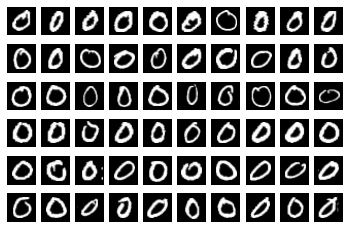

In [220]:
dataiter = iter(training_loaders[0])
images,labels = dataiter.next()
print(images.shape)

figure = plt.figure()
num_of_images = 60
for index in range(1,num_of_images+1):
  plt.subplot(6,10,index)
  plt.axis("off")
  plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')

### Define the network

In [221]:
class NeuralNetwork(nn.Module):
  def __init__(self,classes,channels):
    super().__init__()
    self.conv1 = nn.Conv2d(channels,6,5)
    self.conv2 = nn.Conv2d(6,10,5)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(10*4*4,100)
    self.fc2 = nn.Linear(100,20)
    self.fc3 = nn.Linear(20,classes)
  
  def forward(self,x):
    x = x.unsqueeze(1)
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = F.softmax(x,dim=1)
    return x

### Training the model

In [222]:
def train(model,trainloader):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
  model.train()
  for e in range(epochs):
    running_loss = 0.0
    for _,(images,labels) in enumerate(trainloader):
      optimizer.zero_grad()

      output = model(images)
      loss = criterion(output,labels)

      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    # else:
    #   print(f"Training loss: {running_loss / len(trainloader)}")
  return model

### Testing the model

In [223]:
def test(model,testloader,classes):
  correct = np.zeros(classes,dtype=np.float64)
  total = np.zeros(classes,dtype=np.float64)
  with torch.no_grad():
    for images,labels in testloader:
      output = model(images)
      pred = torch.argmax(output,dim=1)
      for i in range(len(labels)):
        correct[labels[i]] += (pred[i] == labels[i])
        total[labels[i]] += 1
  return (correct,total)

### Prepare initial training set

In [224]:
multi_class_train_set = training_subsets[0] # create initial datasets
multi_class_test_set = testing_subsets[0] # create initial datasets

for i in range(1,num_classes):
  model = NeuralNetwork(i+1,1)
  # concat the training set of the new class with old training set
  multi_class_train_set = ConcatDataset([multi_class_train_set,training_subsets[i]])
  # concat the testing set of the new class with old testing set
  multi_class_test_set = ConcatDataset([multi_class_test_set,testing_subsets[i]])
  # define train loader
  train_loader = DataLoader(multi_class_train_set,batch_size=batch_size,shuffle=True)
  # define test loader
  test_loader = DataLoader(multi_class_test_set,batch_size=batch_size)
  # train the old model with new dataset
  model = train(model,train_loader)
  print(len(train_loader))
  print(test(model,test_loader,i+1))

198
(array([ 977., 1135.]), array([ 980., 1135.]))
291
(array([ 929., 1117.,  774.]), array([ 980., 1135., 1032.]))
387
(array([ 917., 1117.,  862.,  913.]), array([ 980., 1135., 1032., 1010.]))
479
(array([ 953., 1118.,  870.,  910.,  958.]), array([ 980., 1135., 1032., 1010.,  982.]))
563
(array([   0., 1135.,    0.,  197.,    0.,    0.]), array([ 980., 1135., 1032., 1010.,  982.,  892.]))
656
(array([  0.,   0.,   0.,   0., 982.,   0.,   0.]), array([ 980., 1135., 1032., 1010.,  982.,  892.,  958.]))


KeyboardInterrupt: ignored